In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utility_functions import *

# Merge the dataframes of automatic and manual tags

In [257]:
# quotes tagged automatically in the topic modeling phase:
auto_df = pd.read_csv(f"../data/4 - Auto tagged data/auto_tagged_data.csv").rename(columns={"Topic": "AutoTopic"})
# quites tagged manually:
man_df = pd.read_csv("../data/5 - Manually tagged data/manually_tagged_data.csv")[['QuoteText','Topic','OriginalTopic','Topic_Prob']].drop_duplicates('QuoteText').reset_index(drop=True)
man_df.rename(columns={"Topic":"ManualTopic", "OriginalTopic": "AutoTopic"}, inplace=True)
joined_df = man_df.merge(auto_df, on=['QuoteText','AutoTopic','Topic_Prob'], how="left")
joined_df = joined_df[['$Type', 'QuoteWordCount','QuoteLen','StartDate', 'Speaker', 'QuoteText', 'NonStopwordsQuoteText', 'ManualTopic','AutoTopic', 'Topic_Prob', 'Batch', 'TopicWords']]
joined_df.dropna(subset={"ManualTopic"}, inplace=True)
joined_df.loc[joined_df.ManualTopic == "דיור", "ManualTopic"] = "רווחה"
joined_df.head()

,$Type,QuoteWordCount,QuoteLen,StartDate,Speaker,QuoteText,NonStopwordsQuoteText,ManualTopic,AutoTopic,Topic_Prob,Batch,TopicWords
0,Committee,114.0,690.0,2022-01-17 12:00:00,"<< יור >> היו""ר אפרת רייטן מרום: << יור >>",בשיחות שקיימתי עם האוצר ובשיחות שקיימתי אם יוש...,בשיחות שקיימתי האוצר ובשיחות שקיימתי יושב-ראש ...,כלכלי,בטחון,0.984901,3.0,"('0.007*""חיילים"" + 0.004*""וביטחון"" + 0.004*""וע..."
1,Committee,114.0,690.0,2022-01-17 12:00:00,"<< יור >> היו""ר אפרת רייטן מרום: << יור >>",בשיחות שקיימתי עם האוצר ובשיחות שקיימתי אם יוש...,בשיחות שקיימתי האוצר ובשיחות שקיימתי יושב-ראש ...,כלכלי,בטחון,0.984901,3.0,"('0.007*""חיילים"" + 0.004*""וביטחון"" + 0.004*""וע..."
2,Committee,110.0,625.0,2021-03-03 14:00:00,<< דובר >> מיכל וונש (כחול לבן): << דובר >>,"כן בהקשר הנכון, אדוני היושב-ראש, כיוון שהביקור...",בהקשר הנכון היושב-ראש כיוון שהביקורת הסגירה הס...,קורונה,בטחון,0.984432,3.0,"('0.007*""חיילים"" + 0.004*""וביטחון"" + 0.004*""וע..."
3,Committee,133.0,696.0,2017-02-21 11:00:00,"היו""ר דוד אמסלם:","אני אומר בגדול, בסך הכול יש לנו אתרים מקודשים ...",בגדול בסך הכול אתרים מקודשים לעם היהודי לעם הי...,בלי,בטחון,0.984175,3.0,"('0.007*""חיילים"" + 0.004*""וביטחון"" + 0.004*""וע..."
4,Committee,113.0,577.0,2017-02-20 10:30:00,"היו""ר קארין אלהרר:","תראו, אנחנו עוסקים היום בנושא כאוב ועצוב. הוא ...",תראו עוסקים כאוב ועצוב כאוב ועצוב פעמיים רשלנו...,בריאות,בטחון,0.983175,7.0,"('0.004*""הדברים"" + 0.003*""צריכים"" + 0.003*""הבי..."


# Examine trial models' success rates
For each model, I only examined topics that were originally manually marked by me with a topic name. For each of these, I only examined quoted that were tagged manually.
Each model's success is measured by 3 metrics:
- identifying "interesting" quotes: how many of the quotes that the model assigned to a topic were interesting (meaning - not tagged as "no topic")
- Accuracy by topic: for each topic that the model identified, how many of the quotes that the model assigned to that topic were actually tagged with that topic
- Total accuracy: how many of the quotes that the model assigned to a topic were actually tagged with that topic


In [227]:
auto_batch_df = joined_df[['Batch', 'AutoTopic','ManualTopic']].groupby(['Batch','AutoTopic']).count().reset_index().rename(columns={'ManualTopic':'AutoCount', 'AutoTopic':'Topic'})
man_batch_df = joined_df[['Batch', 'AutoTopic','ManualTopic']].groupby(['Batch','ManualTopic']).count().reset_index().rename(columns={'ManualTopic':'Topic', 'AutoTopic':'ManualCount'})

batch_df = auto_batch_df.merge(man_batch_df, how="left", on=['Batch','Topic'])
batch_df['Accuracy'] = batch_df['ManualCount'] * 100 / batch_df['AutoCount']

for batch in sorted(joined_df.Batch.unique()):
    if pd.isna(batch):
        continue
    print(f"--------------------------------------- TRIAL {int(batch)} ---------------------------------------")
    correct_tag = joined_df[(joined_df['Batch'] == batch) & (joined_df['ManualTopic']==joined_df['AutoTopic'])].shape[0]
    incorrect_tag = joined_df[(joined_df['Batch'] == batch) & (joined_df['ManualTopic']!=joined_df['AutoTopic'])].shape[0]
    none_tags = joined_df[(joined_df['Batch'] == batch) & (joined_df['ManualTopic']=='בלי')].shape[0]
    total_tag = joined_df[joined_df['Batch'] == batch].shape[0]
    accuracy = correct_tag * 100 / total_tag
    print(f"Trial model's success in identifying 'interesting' quotes (that has a topic): {'{:.2f}'.format(100 - (none_tags * 100 / total_tag))}%")
    print("\nTrial model accuracy by topic:")
    cur_batch_df = batch_df[batch_df['Batch'] == batch][['Topic','AutoCount','ManualCount','Accuracy']]
    for topic in cur_batch_df.Topic.unique():
        print(f"{topic}: {'{:.2f}'.format(cur_batch_df[cur_batch_df.Topic == topic].Accuracy.values[0])}%")
    print("\nTrial model total accuracy:")
    print(f"Accurate tags: {'{:.2f}'.format(accuracy)}%")
    print(f"Inaccurate tags: {'{:.2f}'.format(100 - accuracy)}% ({'{:.2f}'.format(none_tags * 100 / total_tag)}% are 'non topic')\n")

--------------------------------------- TRIAL 1 ---------------------------------------
Trial model's success in identifying 'interesting' quotes (that has a topic): 69.03%

Trial model accuracy by topic:
בטחון: 60.00%
חינוך: 49.32%
נשים: 25.00%
קורונה: 30.12%

Trial model total accuracy:
Accurate tags: 29.35%
Inaccurate tags: 70.65% (30.97% are 'non topic')

--------------------------------------- TRIAL 2 ---------------------------------------
Trial model's success in identifying 'interesting' quotes (that has a topic): 51.38%

Trial model accuracy by topic:
בריאות: 23.08%
חינוך: 41.67%
נשים: 17.24%
קורונה: 44.83%

Trial model total accuracy:
Accurate tags: 24.77%
Inaccurate tags: 75.23% (48.62% are 'non topic')

--------------------------------------- TRIAL 3 ---------------------------------------
Trial model's success in identifying 'interesting' quotes (that has a topic): 59.57%

Trial model accuracy by topic:
בטחון: 15.28%
בריאות: 39.02%
חינוך: 39.22%
נשים: 33.93%
קורונה: 35.42%

# Examine final tagged data for the classification phase

Total number of tagged quotes: 2741
Amount of interesting quotes (have a topic): 1657
Amount of uninteresting quotes (doesn't have a topic): 1084


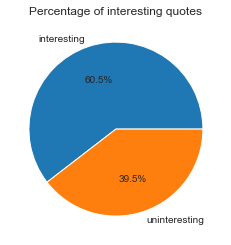

In [228]:
# overview
total = joined_df.shape[0]
non_tags = joined_df[joined_df.ManualTopic == 'בלי'].shape[0]
interesting = 100 - (non_tags* 100 / joined_df.shape[0])
uninteresting = non_tags* 100 / joined_df.shape[0]
print(f"Total number of tagged quotes: {total}")
print(f"Amount of interesting quotes (have a topic): {total - non_tags}")
print(f"Amount of uninteresting quotes (doesn't have a topic): {non_tags}")
x = ["interesting", "uninteresting"]
y = np.array([interesting, uninteresting])
plt.pie(y,labels=x, autopct=lambda pct: "{:1.1f}%".format(pct))
plt.title("Percentage of interesting quotes")
plt.show()

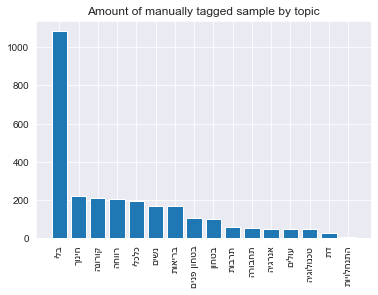

In [229]:
count_df = joined_df['ManualTopic'].value_counts().reset_index().rename(columns={'index':'Topic', 'ManualTopic':'Count'})
count_df['Topic'] = count_df['Topic'].apply(lambda w: w[::-1])
count_df.sort_values(by=['Count'], ascending=False, inplace=True)
plt.bar(count_df.Topic, count_df.Count)
plt.xticks(rotation = 90)
plt.title("Amount of manually tagged sample by topic")
plt.show()

In [231]:
# by topic
topics = sorted(joined_df.ManualTopic.unique())
topic_tuples = []
for topic in topics:
    if topic == "בלי":
        continue
    total_man_samples = joined_df[joined_df.ManualTopic == topic].shape[0]
    man_sample_match = joined_df[(joined_df.ManualTopic == topic) & (joined_df.AutoTopic == topic)].shape[0]
    auto_samples = joined_df[joined_df['AutoTopic'] == topic].shape[0]
    accuracy = '{:.2f}'.format(man_sample_match * 100 / auto_samples) if auto_samples != 0 else -1
    topic_tuples.append((topic,total_man_samples, auto_samples, accuracy))
topic_tuples.sort(key=lambda x: float(x[3]), reverse=True)

for topic,man, auto, acc in topic_tuples:
    print(f"------------------------------------ {topic} ------------------------------------")
    print(f"Amount of manually tagged samples: {man}")
    print(f"Amount of automatically tagged samples: {auto}")
    if acc != -1:
        print(f"Accuracy of automatic tag among all trials: {acc}%")
    print()

------------------------------------ קורונה ------------------------------------
Amount of manually tagged samples: 212
Amount of automatically tagged samples: 503
Accuracy of automatic tag among all trials: 30.62%

------------------------------------ חינוך ------------------------------------
Amount of manually tagged samples: 220
Amount of automatically tagged samples: 505
Accuracy of automatic tag among all trials: 30.50%

------------------------------------ נשים ------------------------------------
Amount of manually tagged samples: 170
Amount of automatically tagged samples: 499
Accuracy of automatic tag among all trials: 23.05%

------------------------------------ רווחה ------------------------------------
Amount of manually tagged samples: 205
Amount of automatically tagged samples: 374
Accuracy of automatic tag among all trials: 19.79%

------------------------------------ בריאות ------------------------------------
Amount of manually tagged samples: 168
Amount of automatica

## Choose final topics for the classification phase

In [254]:
topics_df = count_df = joined_df['ManualTopic'].value_counts().reset_index().rename(columns={'index':'Topic', 'ManualTopic':'SampleCount'}).iloc[1:9, :]
final_topics = list(topics_df.Topic.unique()) + ['בלי']
print("Final number of samples for classification phase:", topics_df.SampleCount.sum())
print("Final sample count by topic:")
topics_df

Final number of samples for classification phase: 1374
Final sample count by topic:


,Topic,SampleCount
1,חינוך,220
2,קורונה,212
3,רווחה,205
4,כלכלי,195
5,נשים,170
6,בריאות,168
7,בטחון פנים,103
8,בטחון,101


In [256]:
# save final topics to file
final_df = joined_df[joined_df.ManualTopic.isin(final_topics)]
final_df = final_df[['$Type', 'QuoteWordCount', 'QuoteLen', 'StartDate', 'Speaker','QuoteText', 'NonStopwordsQuoteText', 'ManualTopic']]
final_df.rename(columns={"$Type": "Type", "ManualTopic": "Tag"}, inplace=True)
final_df.to_csv("../data/6 - Classification data/full_classification_df.csv", index=False)
final_df

,Type,QuoteWordCount,QuoteLen,StartDate,Speaker,QuoteText,NonStopwordsQuoteText,Tag
0,Committee,114.0,690.0,2022-01-17 12:00:00,"<< יור >> היו""ר אפרת רייטן מרום: << יור >>",בשיחות שקיימתי עם האוצר ובשיחות שקיימתי אם יוש...,בשיחות שקיימתי האוצר ובשיחות שקיימתי יושב-ראש ...,כלכלי
1,Committee,114.0,690.0,2022-01-17 12:00:00,"<< יור >> היו""ר אפרת רייטן מרום: << יור >>",בשיחות שקיימתי עם האוצר ובשיחות שקיימתי אם יוש...,בשיחות שקיימתי האוצר ובשיחות שקיימתי יושב-ראש ...,כלכלי
2,Committee,110.0,625.0,2021-03-03 14:00:00,<< דובר >> מיכל וונש (כחול לבן): << דובר >>,"כן בהקשר הנכון, אדוני היושב-ראש, כיוון שהביקור...",בהקשר הנכון היושב-ראש כיוון שהביקורת הסגירה הס...,קורונה
3,Committee,133.0,696.0,2017-02-21 11:00:00,"היו""ר דוד אמסלם:","אני אומר בגדול, בסך הכול יש לנו אתרים מקודשים ...",בגדול בסך הכול אתרים מקודשים לעם היהודי לעם הי...,בלי
4,Committee,113.0,577.0,2017-02-20 10:30:00,"היו""ר קארין אלהרר:","תראו, אנחנו עוסקים היום בנושא כאוב ועצוב. הוא ...",תראו עוסקים כאוב ועצוב כאוב ועצוב פעמיים רשלנו...,בריאות
...,...,...,...,...,...,...,...,...
2736,Committee,75.0,433.0,2022-02-21 10:15:00,"<< יור >> היו""ר אבתיסאם מראענה: << יור >>",בוקר טוב לכולן ולכולם. אז אנחנו שמחות ושמחים ל...,לכולן ולכולם שמחות ושמחים לקיים מעקב אלימות מי...,נשים
2737,Committee,52.0,268.0,2017-11-14 11:30:00,מרב תורג'מן:,"נכון. כידוע הצעת החוק מסדירה שני נושאים, אחד ז...",כידוע מסדירה נושאים הפטור מחובת ביטוח רכב רכוש...,בטחון פנים
2738,Committee,87.0,502.0,2016-11-28 11:15:00,"היו""ר משה גפני:",אנחנו דנים עכשיו בפיצויים ובשיקום לנפגעי ולנזק...,דנים בפיצויים ובשיקום לנפגעי ולנזקי השריפות עס...,בטחון פנים
2739,Committee,75.0,413.0,2021-12-21 10:30:00,"<< יור >> היו""ר שרן מרים השכל: << יור >>","ועדת המשנה מאוד מאוד חשובה, הוועדה תעסוק בחינו...",חשובה תעסוק בחינוך הממלכתי-דתי ששם אתגרים בלתי...,חינוך


## Final classification data EDA

In [ ]:
stop_words = get_stopwords()
text = final_df["QuoteText"]
plot_top_n_words_hist(text, 25, stop_words, plot_non_stopwords=True, print_non_stopwords=True)

In [ ]:
plot_top_n_bigrams_hist(text, stop_words, 25, True)